### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [34]:
%reload_ext autoreload
%autoreload 2
import numpy
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [35]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
data = ReadCurrentAndField (foldername,filepattern)
fileList = glob.glob(foldername+filepattern)
position = data[:,:,:15].reshape(-1,15)
Bfield = data[:,:,15:].reshape(-1,3)
print(fileList)
print(data.shape)
print('Bfield shape', Bfield.shape)


            0          1          2          3          4          5   \
0    13.377536  -7.211070   0.741187   3.370891 -11.227984  10.886728   
1    13.990121  -2.347604 -12.810453  12.602935  -7.506053   5.667563   
2    -7.150359 -14.938438 -10.461355 -10.448156  -3.929637 -11.385478   
3    -8.407322   0.873758  14.415918   1.850328 -10.669980  -7.484029   
4    -7.659824   4.255773   5.158273  -4.331816  11.511097  -6.343674   
..         ...        ...        ...        ...        ...        ...   
995   6.868029  12.163486  -3.450635   5.535166   0.832927   1.170504   
996   9.416658   9.348362  -3.951384   9.788224   4.646395 -14.646981   
997  14.337277  12.576514  -2.429953   6.235643  -9.712057  -6.517787   
998   9.993018  -4.585545  -8.394262  13.706213   3.590820  -6.131998   
999 -12.319459   6.683977 -13.610929  13.977406   2.508146  -9.246351   

            6          7          8          9          10         11  
0    -5.343411  -0.894705   1.191360   1.474581   4

In [36]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop import train_part


batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=position,
    train_y=Bfield
)

# split the dataset to train, validation, test
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.2,0.1])

#Using Dataloader for batch train
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)


###############################################
# Config the neural network
###############################################
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)
epochs = 50
learning_rate_decay = .1
learning_rates = [1e-3]
schedule = []
weight_decays = [0]


################################################
# Train the neural network
################################################

for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        fc_network.apply(weight_init)
        optimizer = torch.optim.Adam([{'params':fc_network.parameters()}], lr=learning_rate, weight_decay= weight_decay)
        RMSE_history, RMSE_val_history, loss_history, iter_history = train_part(model=fc_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, verbose=False, device=device)


Epoch 0, Iteration 50647, loss = 0.0000


c:\Users\14032\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Got RMSE 0.009617285802960396
Got RMSE 0.00961909070611

Epoch 1, Iteration 101294, loss = 0.0001
Got RMSE 0.008965225890278816
Got RMSE 0.00896310806274414

Epoch 2, Iteration 151941, loss = 0.0001
Got RMSE 0.008625844493508339
Got RMSE 0.008623505011200905

Epoch 3, Iteration 202588, loss = 0.0002
Got RMSE 0.00835481658577919
Got RMSE 0.008352378383278847

Epoch 4, Iteration 253235, loss = 0.0000
Got RMSE 0.008123267441987991
Got RMSE 0.008120345883071423

Epoch 5, Iteration 303882, loss = 0.0000
Got RMSE 0.00813775509595871
Got RMSE 0.008134807460010052

Epoch 6, Iteration 354529, loss = 0.0000
Got RMSE 0.008106914348900318
Got RMSE 0.008103606291115284

Epoch 7, Iteration 405176, loss = 0.0001
Got RMSE 0.008018829859793186
Got RMSE 0.008015874773263931

Epoch 8, Iteration 455823, loss = 0.0000
Got RMSE 0.008037999272346497
Got RMSE 0.008036433719098568

Epoch 9, Iteration 506470, loss = 0.0000
Got RMSE 0.007984687574207783
Got RMSE 0.007982265204191208

Epoch 10, Iteration 557117, 

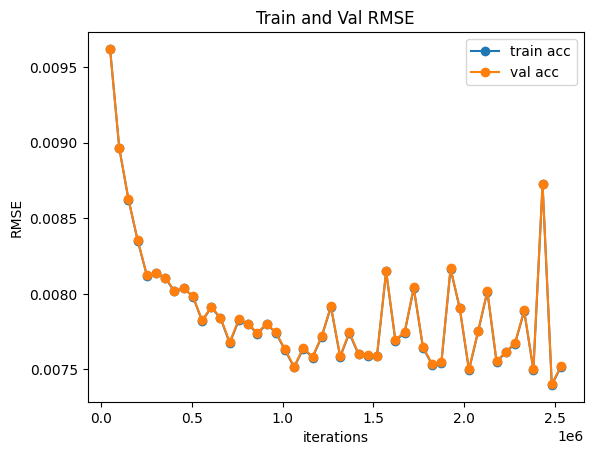

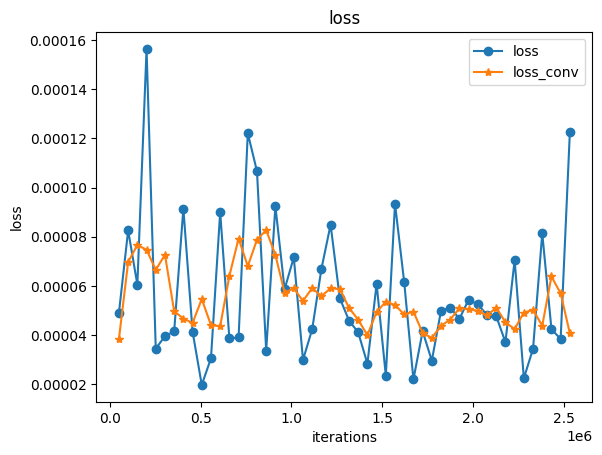

In [38]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val RMSE')
plt.plot(iter_history,RMSE_history,'-o')
plt.plot(iter_history,RMSE_val_history,'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.show()

plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()